<p>Get all the required libraries. We are using following libraries
<ul>
<li>Requests- to retrieve the web page with our data.</li>
<li>Beautiful Soup- for Screen Scraping</li>
<li>Pandas- for storing the data</li>
</ul>
</p>

In [56]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import sys
import pandas as pd


def crawl(url):
    while True:
        try:
        r = requests.get(url)
        return r
    except Exception as e:
        print e
        sleep(2)
        print "retrying to fetch URL!!!"

# http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;orderby=start;page=153;spanmax1=31+Dec+2013;spanmin1=1+jan+1989;spanval1=span;team=6;template=results;type=batting;view=match
def getBattingStats():
	# there are total 153 pages for the data from 1989 to 2013
    name = []
    batsmanStatus = []
    batStatMatch=[]
    runs = []
    balls = []
    strikeRate = []
    opponent = []
    venue = []
    date = []
    count = 0
    for page in range(1, 195):
        count+=1
        sys.stdout.write("\r" + "\tCrawling Innings Page: %d of 194" % count)
        sys.stdout.flush()
        url = "http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;orderby=start;page={};spanmax2=31+Dec+2015;spanmin2=1+jan+1980;spanval2=span;team=6;template=results;type=batting;view=innings".format(page)
		# Scrape the HTML at the url
        r = crawl(url)
        # Turn the HTML into a Beautiful Soup object
        soup = BeautifulSoup(r.text, "lxml")
        table = soup.find('table', attrs={'class': 'engineTable'})
        tbody = soup.find('tbody')
        rows = tbody.findAll('tr', attrs={'class': 'data1'})
        for tr in rows:
            cols = tr.findAll('td')
            record = [td.text for td in cols]
            name.append(str(record[0]))
                    # if score contains '*' batsman is not out
            batsmanStatus.append(('out', 'not out')['*' in str(record[1])])
            batStatMatch.append(str(record[1]))
            run=str(record[1])
            if '*' in run:
                run=int(run[:-1])
            elif run=='DNB' or run=='TDNB'or run=='sub':
                run=0
            else:
                run=int(run)
            runs.append(run)
                # runs.append((int(record[2]),None)[])
            balls.append(None if str(record[3]) == '-' else int(record[3]))
            strikeRate.append(None if str(record[6]) == '-' else float(record[6]))
            opponent.append(str(record[9])[2:])
            venue.append(str(record[10]))
            date.append(str(record[11]))
            battingStat = pd.DataFrame({
                                       'player': name,
                                       'outStatus': batsmanStatus,
                                       'runs': runs,
                                       'ballsFaced': balls,
                                       'strikeRate': strikeRate,
                                       'opponent': opponent,
                                       'venue': venue,
                                       'date': date
                                       })
    print"Crawling for Batting Stats completed..."
    return battingStat


Scrapping the ESPN Cric Info Website for the stats for the timeframe of 1989 to 2013

In [57]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import sys

# http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;page=1;spanmax1=31+Dec+2013;spanmin1=1+jan+1989;spanval1=span;team=6;template=results;type=team;view=results
def getMatchStats():
  count=0
  teamName=[]
  result=[]
  margin=[]
  ballsRemaining=[]
  toss=[]
  batInning=[]
  opponent=[]
  venue=[]
  date=[]
  for page in range(1,20):
    count+=1
    sys.stdout.write("\r" + "\tCrawling Results Page: %d of 19" % count)
    sys.stdout.flush()
    url="http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;page={};spanmax2=31+Dec+2015;spanmin2=1+jan+1980;spanval2=span;team=6;template=results;type=team;view=results".format(page)
    r=crawl(url)
    soup = BeautifulSoup(r.text, "lxml")
    table = soup.find('table', attrs={'class': 'engineTable'})
    tbody = soup.find('tbody')
    rows = tbody.findAll('tr', attrs={'class': 'data1'})
    for tr in rows:
      cols = tr.findAll('td')
      record = [td.text for td in cols]
      teamName.append(str(record[0]))
      result.append(str(record[1]))
      margin.append(str(record[2]))
      ballsRemaining.append(str(record[3]))
      toss.append(str(record[4]))
      batInning.append(str(record[5]))
      opponent.append(str(record[7])[2:])
      venue.append(str(record[8]))
      date.append(str(record[9]))
      matchStat=pd.DataFrame({
                             'team':teamName,
                             'result':result,
                             'margin':margin,
                             'br':ballsRemaining,
                             'toss':toss,
                             'batInning':batInning,
                             'opponent': opponent,
                             'venue': venue,
                             'date': date
                             })
  print"Crawling for Match Stats completed..."
  return matchStat


In [58]:
import time

starttime=time.time()
print"\n"
print "\nGetting Stats for Every batsmen inning by inning"
battingStatDF=getBattingStats() 
print"\n"
print "\nGetting Match Statistics"
matchStatDF=getMatchStats()
print"\n"
end=time.time()
print "\tTotal Time Taken :"+str(end-starttime) 



Getting Stats for Every batsmen inning by inning
	Crawling Innings Page: 194 of 194Crawling for Batting Stats completed...

Getting Match Statistics
	Crawling Results Page: 19 of 19Crawling for Match Stats completed...


913
878
	Total Time Taken :285.051000118


In [122]:
import matplotlib.pyplot as plt
%matplotlib inline  
statDF=battingStatDF.merge(matchStatDF, on='date',how='inner')
statDF.drop(['opponent_y','venue_y','team'],axis=1,inplace=True)


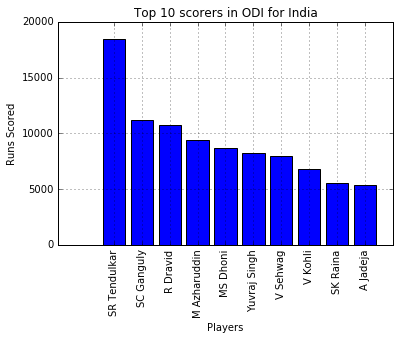

In [123]:
newDF=dict(statDF.groupby(by=['player'])['runs'].sum())
newDF=sorted(newDF.items(), key=lambda x: x[1],reverse=True)
player=zip(*newDF)[0]
runs=zip(*newDF)[1]
# plt.bar(player[:10], runs[:10])
plt.bar(range(len(player[:10])), runs[:10], align='center')
plt.xticks(range(len(player[:10])), player[:10], rotation='vertical')
plt.ylabel('Runs Scored')
plt.xlabel('Players')
plt.grid(True)
plt.title('Top 10 scorers in ODI for India')

In [132]:
newDF=dict(statDF.groupby(by=['player','result'])['runs'].sum())
newDF=sorted(newDF.items(), key=lambda x: x[1],reverse=True)
newDF

[(('SR Tendulkar', 'won'), 11157),
 (('SC Ganguly', 'won'), 6818),
 (('SR Tendulkar', 'lost'), 6585),
 (('R Dravid', 'won'), 5729),
 (('Yuvraj Singh', 'won'), 5622),
 (('V Sehwag', 'won'), 5605),
 (('MS Dhoni', 'won'), 5056),
 (('M Azharuddin', 'won'), 4992),
 (('V Kohli', 'won'), 4987),
 (('R Dravid', 'lost'), 4686),
 (('SC Ganguly', 'lost'), 4295),
 (('M Azharuddin', 'lost'), 4085),
 (('G Gambhir', 'won'), 3936),
 (('SK Raina', 'won'), 3650),
 (('MS Dhoni', 'lost'), 3204),
 (('NS Sidhu', 'won'), 3005),
 (('RG Sharma', 'won'), 2832),
 (('A Jadeja', 'won'), 2727),
 (('A Jadeja', 'lost'), 2530),
 (('Yuvraj Singh', 'lost'), 2484),
 (('K Srikkanth', 'won'), 2305),
 (('V Sehwag', 'lost'), 2161),
 (('S Dhawan', 'won'), 2112),
 (('N Kapil Dev', 'lost'), 2043),
 (('RJ Shastri', 'lost'), 1876),
 (('K Srikkanth', 'lost'), 1765),
 (('DB Vengsarkar', 'lost'), 1755),
 (('V Kohli', 'lost'), 1741),
 (('VG Kambli', 'won'), 1738),
 (('SK Raina', 'lost'), 1718),
 (('RG Sharma', 'lost'), 1643),
 (('N Ka

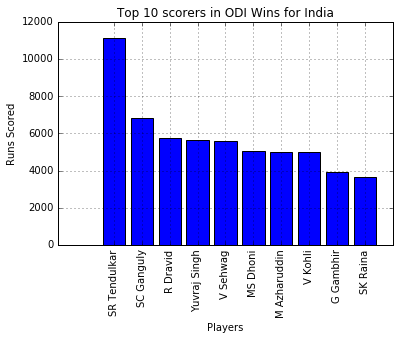

In [145]:
win={}
lost={}
other={}
for record in newDF:
    if record[0][1]=='won':
        win[record[0][0]]=record[1]
    elif record[0][1]=='lost':
        lost[record[0][0]]=record[1]
    else:
        other[record[0][0]]=record[1]
win=sorted(win.items(), key=lambda x: x[1],reverse=True)
lost=sorted(lost.items(), key=lambda x: x[1],reverse=True)
playerWin=zip(*win)[0]
runsWin=zip(*win)[1]
plt.bar(range(len(playerWin[:10])), runsWin[:10], align='center')
plt.xticks(range(len(playerWin[:10])), playerWin[:10], rotation='vertical')
plt.ylabel('Runs Scored')
plt.xlabel('Players')
plt.grid(True)
plt.title('Top 10 scorers in ODI Wins for India')



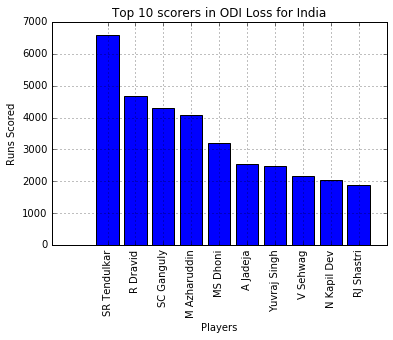

In [146]:
playerLoss=zip(*lost)[0]
runsLoss=zip(*lost)[1]
plt.bar(range(len(playerLoss[:10])), runsLoss[:10], align='center')
plt.xticks(range(len(playerLoss[:10])), playerLoss[:10], rotation='vertical')
plt.ylabel('Runs Scored')
plt.xlabel('Players')
plt.grid(True)
plt.title('Top 10 scorers in ODI Loss for India')